# In Codice Ratio Convolutional Neural Network - Test on words

In [1]:
import os.path
from IPython.display import Image
import time

from util import Util
u = Util()
import image_utils as iu
import keras_image_utils as kiu

import numpy as np
# Explicit random seed for reproducibility
np.random.seed(1337)

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Merge

In [3]:
import dataset_generator as dataset

## Loading test sets

In [4]:
# letter list
ALPHABET_ALL = dataset.ALPHABET_ALL

(_, _, X_test_22, y_test_22, _) = dataset.generate_all_chars_with_class(verbose=0, plot=False)
(input_shape, X_test_22, Y_test_22) = kiu.adjust_input_output(X_test_22, y_test_22, 22) 
print ("Loaded test set for all the characters")

(_, _, X_test_seg, y_test_seg) = dataset.generate_dataset_for_segmentator(verbose=0, plot=False)
(_, X_test_seg, Y_test_seg) = kiu.adjust_input_output(X_test_seg, y_test_seg, 2)
print ("Loaded test set for good and bad segments")

X_test_char = {}
y_test_char = {}
Y_test_char = {}
for char in ALPHABET_ALL:
    (_, _, X_test_char[char], y_test_char[char]) = dataset.generate_positive_and_negative_labeled(char, verbose=0)
    (_, X_test_char[char], Y_test_char[char]) = kiu.adjust_input_output(X_test_char[char], y_test_char[char], 2)
    print ("Loaded test set for char '" + char + "'")

Loaded test set for all the characters
Loaded test set for good and bad segments
Loaded test set for char 'a'
Loaded test set for char 'c'
Loaded test set for char 'd_mediana'
Loaded test set for char 'e'
Loaded test set for char 'i'
Loaded test set for char 'm'
Loaded test set for char 'n'
Loaded test set for char 'o'
Loaded test set for char 'r'
Loaded test set for char 's_mediana'
Loaded test set for char 't'
Loaded test set for char 'u'
Loaded test set for char 'd_alta'
Loaded test set for char 's_alta'
Loaded test set for char 'b'
Loaded test set for char 'f'
Loaded test set for char 'h'
Loaded test set for char 'l'
Loaded test set for char 'g'
Loaded test set for char 'p'
Loaded test set for char 'q'
Loaded test set for char 's_bassa'


## Constants

In [5]:
# input image dimensions
img_rows, img_cols = 34, 56

# number of networks for ensamble learning
number_of_models = 5

# checkpoints dir
checkpoints_dir = "checkpoints"

# size of pooling area for max pooling
pool_size1 = (2, 2)
pool_size2 = (3, 3)
# convolution kernel size
kernel_size1 = (4, 4)
kernel_size2 = (5, 5)
# dropout rate
dropout = 0.15
# activation
activation = 'relu'

## Helper functions for model definition and load

In [6]:
def initialize_network_single_column(model, nb_classes, nb_filters1, nb_filters2, dense_layer_size1):
    model.add(Convolution2D(nb_filters1, kernel_size1[0], kernel_size1[1],
                            border_mode='valid',
                            input_shape=input_shape, name='covolution_1_' + str(nb_filters1) + '_filters'))
    model.add(Activation(activation, name='activation_1_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size1, name='max_pooling_1_' + str(pool_size1) + '_pool_size'))
    model.add(Convolution2D(nb_filters2, kernel_size2[0], kernel_size2[1]))
    model.add(Activation(activation, name='activation_2_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size2, name='max_pooling_1_' + str(pool_size2) + '_pool_size'))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(dense_layer_size1, name='fully_connected_1_' + str(dense_layer_size1) + '_neurons'))
    model.add(Activation(activation, name='activation_3_' + activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes, name='output_' + str(nb_classes) + '_neurons'))
    model.add(Activation('softmax', name='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy', 'precision', 'recall'])

def try_load_checkpoints(model, checkpoints_filepath, warn=True):
    # loading weights from checkpoints 
    if os.path.exists(checkpoints_filepath):
        model.load_weights(checkpoints_filepath)
    elif warn: 
        print('Warning: ' + checkpoints_filepath + ' could not be loaded')

def initialize_network_multi_column(merged_model, models):
    merged_model.add(Merge(models, mode='ave'))
    merged_model.compile(loss='categorical_crossentropy',
                         optimizer='adadelta',
                         metrics=['accuracy', 'precision', 'recall'])

def create_and_load_network(number_of_models, checkpoint_paths, nb_classes, 
                            nb_filters1, nb_filters2, dense_layer_size1):
    # pseudo random generation of seeds
    seeds = np.random.randint(10000, size=number_of_models)

    # initializing all the models
    models = [None] * number_of_models

    for i in range(number_of_models):
        models[i] = Sequential()
        initialize_network_single_column(models[i], nb_classes, nb_filters1, nb_filters2, dense_layer_size1)
        try_load_checkpoints(models[i], checkpoint_paths[i])
        
    # initializing merged model
    merged_model = Sequential()
    initialize_network_multi_column(merged_model, models)
    
    return (merged_model, models)

## Model load

In [7]:
# 22 classes ocr
ocr_weigts_dir = os.path.join(checkpoints_dir, "09_22-classes")

ocr_weights = [os.path.join(ocr_weigts_dir, "09_ICR_weights.best_0.hdf5"), 
               os.path.join(ocr_weigts_dir, "09_ICR_weights.best_1.hdf5"),
               os.path.join(ocr_weigts_dir, "09_ICR_weights.best_2.hdf5"),
               os.path.join(ocr_weigts_dir, "09_ICR_weights.best_3.hdf5"),
               os.path.join(ocr_weigts_dir, "09_ICR_weights.best_4.hdf5")]
(ocr_model, _) = create_and_load_network(5, ocr_weights, 22, 50, 100, 250)
score = ocr_model.evaluate([np.asarray(X_test_22)] * number_of_models, Y_test_22, verbose=0)
print ("Loaded 22 classes orc model with test error of ", (1-score[2])*100, '%')

# segmentator network (good cut / bad cut)
segmentator_weigts_dir = os.path.join(checkpoints_dir, "letter_not_letter")

segmentator_weights = [os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_0.hdf5"), 
                       os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_1.hdf5"),
                       os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_2.hdf5"),
                       os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_3.hdf5"),
                       os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_4.hdf5")]
(segmentator_model, _) = create_and_load_network(5, segmentator_weights, 2, 50, 100, 250)
score = segmentator_model.evaluate([np.asarray(X_test_seg)] * number_of_models, Y_test_seg, verbose=0)
print ("Loaded binary segmentator model with test error of ", (1-score[2])*100, '%')
print ("---")

# single letter segmentator / ocr 
single_letter_models = {}
single_letter_weights_dir = {}
single_letter_weights = {}
errors = []
for char in ALPHABET_ALL:
    single_letter_weights_dir[char] = os.path.join(checkpoints_dir, char)

    single_letter_weights[char] = [os.path.join(single_letter_weights_dir[char], "0.hdf5"), 
                                   os.path.join(single_letter_weights_dir[char], "1.hdf5"),
                                   os.path.join(single_letter_weights_dir[char], "2.hdf5"),
                                   os.path.join(single_letter_weights_dir[char], "3.hdf5"),
                                   os.path.join(single_letter_weights_dir[char], "4.hdf5")]
    (single_letter_models[char], _) = create_and_load_network(5, single_letter_weights[char], 2, 20, 40, 150)
    score = single_letter_models[char].evaluate([np.asarray(X_test_char[char])] * number_of_models, Y_test_char[char], verbose=0)
    print ("Loaded binary model for '" + char + "', with test error of ", (1-score[2])*100, '%')
    errors.append(1-score[2])
print("Average test error: ", sum(errors) / float(len(errors)) * 100, "%")

Loaded 22 classes orc model with test error of  4.60439568125 %
Loaded binary segmentator model with test error of  5.8471036873 %
---
Loaded binary model for 'a', with test error of  5.76923082017 %
Loaded binary model for 'c', with test error of  7.44680889109 %
Loaded binary model for 'd_mediana', with test error of  3.4482760676 %
Loaded binary model for 'e', with test error of  3.34158415842 %
Loaded binary model for 'i', with test error of  17.9824561404 %
Loaded binary model for 'm', with test error of  9.44700471817 %
Loaded binary model for 'n', with test error of  11.2903225593 %
Loaded binary model for 'o', with test error of  7.35294129334 %
Loaded binary model for 'r', with test error of  6.66666653421 %
Loaded binary model for 's_mediana', with test error of  3.33333611488 %
Loaded binary model for 't', with test error of  5.47945205479 %
Loaded binary model for 'u', with test error of  15.5487804878 %
Loaded binary model for 'd_alta', with test error of  2.32558139535 %


## Helper functions for prediction

In [43]:
def predict_pipeline1(data, count_letter=True):
    start_time = time.time()
    count = 0
    for bad_cut in data:
        flag = False
        count += 1
        bad_cuts = np.asarray([bad_cut])
        if count_letter:
            print ("Predictions for the supposed letter number " + str(count))
        for char in ALPHABET_ALL:
            predictions = single_letter_models[char].predict([bad_cuts] * number_of_models)
            if (predictions[0][1] > predictions[0][0]):
                print ("Cut " + str(count) + " has been classified as good corresponding to char '" +\
                       char + "' with a confidence of " + str(predictions[0][1] * 100) + "%")
                flag = True
        if not flag:
            print ("Bad cut")
        print ("---")
    elapsed_time = time.time() - start_time
    print("Elapsed time:", elapsed_time)
        
def predict_pipeline2(data, count_letter=True):
    start_time = time.time()
    count = 0
    for bad_cut in data:
        count += 1
        bad_cuts = np.asarray([bad_cut])
        if count_letter:
            print ("Predictions for the supposed letter number " + str(count))
        predictions = segmentator_model.predict([bad_cuts] * number_of_models)
        if (predictions[0][1] > predictions[0][0]):
            predictions = ocr_model.predict([bad_cuts] * number_of_models)
            ind = (-predictions[0]).argsort()[:3]
            for i in ind:
                print ("Good cut corresponding to letter '" + ALPHABET_ALL[i] + \
                   "' with a confidence of " + str(predictions[0][i] * 100) + "%")
        else: 
            print ("Bad cut with a confidence of " + str(predictions[0][0] * 100) + "%")
        print ("---")
    elapsed_time = time.time() - start_time
    print("Elapsed time:", elapsed_time)
        
def predict_pipeline3(data, count_letter=True):
    start_time = time.time()
    count = 0
    for bad_cut in data:
        flag = False
        count += 1
        bad_cuts = np.asarray([bad_cut])
        if count_letter:
            print ("Predictions for the supposed letter number " + str(count))
        for char in ALPHABET_ALL:
            predictions = single_letter_models[char].predict([bad_cuts] * number_of_models)
            if (predictions[0][1] > predictions[0][0]):
                print ("Good cut with a confidence of " + str(predictions[0][1] * 100) + "% by letter '" + char + "'")
                flag = True
        if flag:
            predictions = ocr_model.predict([bad_cuts] * number_of_models)
            ind = (-predictions[0]).argsort()[:3]
            for i in ind:
                print ("Good cut corresponding to letter '" + ALPHABET_ALL[i] + \
                   "' with a confidence of " + str(predictions[0][i] * 100) + "%")
        else: 
            print ("Bad cut")
        print ("---")
    elapsed_time = time.time() - start_time
    print("Elapsed time:", elapsed_time)

def predict_pipeline4(data, count_letter=True):
    start_time = time.time()
    count = 0
    for bad_cut in data:
        count += 1
        bad_cuts = np.asarray([bad_cut])
        if count_letter:
            print ("Predictions for the supposed letter number " + str(count))
        predictions = segmentator_model.predict([bad_cuts] * number_of_models)
        if (predictions[0][1] > predictions[0][0]):
            for char in ALPHABET_ALL:
                predictions = single_letter_models[char].predict([bad_cuts] * number_of_models)
                if (predictions[0][1] > predictions[0][0]):
                    print ("Good cut with a confidence of " + str(predictions[0][1] * 100) + "% by letter '" + char + "'")
        else: 
            print ("Bad cut with a confidence of " + str(predictions[0][0] * 100) + "%")
        print ("---")
    elapsed_time = time.time() - start_time
    print("Elapsed time:", elapsed_time)

## Experiment 1 ("asseras")

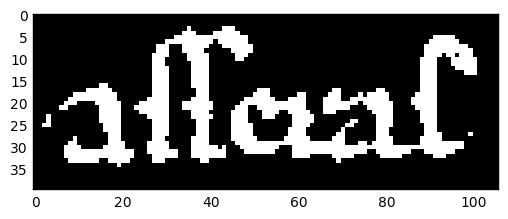

In [44]:
u.plot_image(iu.load_sample("not_code/words/asseras.png"), (40, 106))

### Bad cuts

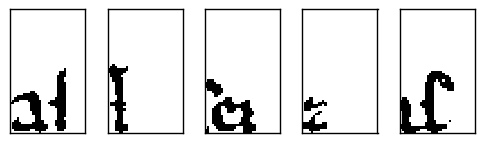

In [45]:
asseras_bad_cuts = iu.open_many_samples( \
                  ["not_code/words/bad_cuts/asseras/1.png",
                   "not_code/words/bad_cuts/asseras/2.png",
                   "not_code/words/bad_cuts/asseras/3.png",
                   "not_code/words/bad_cuts/asseras/4.png",
                   "not_code/words/bad_cuts/asseras/5.png"])
(asseras_bad_cuts, _) = kiu.adjust_input(np.asarray(asseras_bad_cuts))

u.plot_some_images(asseras_bad_cuts, (img_cols, img_rows), grid_x=5, grid_y=1)

#### Pipeline 1 (22 networks as segmentator and classifier)

In [46]:
predict_pipeline1(asseras_bad_cuts)

Predictions for the supposed letter number 1
Bad cut
---
Predictions for the supposed letter number 2
Cut 2 has been classified as good corresponding to char 'l' with a confidence of 98.24436903%
---
Predictions for the supposed letter number 3
Cut 3 has been classified as good corresponding to char 's_mediana' with a confidence of 99.3959903717%
Cut 3 has been classified as good corresponding to char 'd_alta' with a confidence of 52.2549033165%
---
Predictions for the supposed letter number 4
Bad cut
---
Predictions for the supposed letter number 5
Cut 5 has been classified as good corresponding to char 's_mediana' with a confidence of 86.8310153484%
Cut 5 has been classified as good corresponding to char 's_alta' with a confidence of 88.0569458008%
---
Elapsed time: 0.6684665679931641


**Possible word:** -ls-s

#### Pipeline 2 (segmentator + classifier)

In [47]:
predict_pipeline2(asseras_bad_cuts)

Predictions for the supposed letter number 1
Bad cut with a confidence of 99.9959170818%
---
Predictions for the supposed letter number 2
Bad cut with a confidence of 52.9310405254%
---
Predictions for the supposed letter number 3
Bad cut with a confidence of 98.1395363808%
---
Predictions for the supposed letter number 4
Bad cut with a confidence of 99.6289908886%
---
Predictions for the supposed letter number 5
Good cut corresponding to letter 's_alta' with a confidence of 95.2699542046%
Good cut corresponding to letter 'f' with a confidence of 4.72010560334%
Good cut corresponding to letter 's_bassa' with a confidence of 0.00890376686584%
---
Elapsed time: 0.03605294227600098


**Possible word:** ----s

#### Pipeline 3 (22 networks as segmentator + classifier)

In [48]:
predict_pipeline3(asseras_bad_cuts)

Predictions for the supposed letter number 1
Bad cut
---
Predictions for the supposed letter number 2
Good cut with a confidence of 98.24436903% by letter 'l'
Good cut corresponding to letter 'l' with a confidence of 99.9999880791%
Good cut corresponding to letter 's_alta' with a confidence of 1.0037138054e-05%
Good cut corresponding to letter 'h' with a confidence of 6.2676763779e-08%
---
Predictions for the supposed letter number 3
Good cut with a confidence of 99.3959903717% by letter 's_mediana'
Good cut with a confidence of 52.2549033165% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 96.7134594917%
Good cut corresponding to letter 's_mediana' with a confidence of 2.20283605158%
Good cut corresponding to letter 'b' with a confidence of 0.460295099765%
---
Predictions for the supposed letter number 4
Bad cut
---
Predictions for the supposed letter number 5
Good cut with a confidence of 86.8310153484% by letter 's_mediana'
Good cut with a confidenc

**Possible word:** -ld-s

#### Pipeline 4 (segmentator + 22 networks as classifier)

In [49]:
predict_pipeline4(asseras_bad_cuts)

Predictions for the supposed letter number 1
Bad cut with a confidence of 99.9959170818%
---
Predictions for the supposed letter number 2
Bad cut with a confidence of 52.9310405254%
---
Predictions for the supposed letter number 3
Bad cut with a confidence of 98.1395363808%
---
Predictions for the supposed letter number 4
Bad cut with a confidence of 99.6289908886%
---
Predictions for the supposed letter number 5
Good cut with a confidence of 86.8310153484% by letter 's_mediana'
Good cut with a confidence of 88.0569458008% by letter 's_alta'
---
Elapsed time: 0.17174935340881348


**Possible word: ** -----

### Good cuts

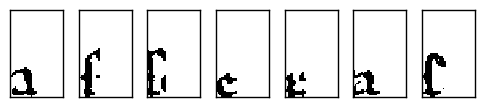

In [50]:
asseras_good_cuts = iu.open_many_samples( \
                    ["not_code/words/good_cuts/asseras/a1.png",
                     "not_code/words/good_cuts/asseras/f1.png",
                     "not_code/words/good_cuts/asseras/f2.png",
                     "not_code/words/good_cuts/asseras/e.png",
                     "not_code/words/good_cuts/asseras/r.png",
                     "not_code/words/good_cuts/asseras/a2.png",
                     "not_code/words/good_cuts/asseras/s.png"])
(asseras_good_cuts, _) = kiu.adjust_input(np.asarray(asseras_good_cuts))

u.plot_some_images(asseras_good_cuts, (img_cols, img_rows), grid_x=7, grid_y=1)

#### Pipeline 1 (22 networks as segmentator and classifier)

In [51]:
predict_pipeline1(asseras_good_cuts)

Predictions for the supposed letter number 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 91.9330716133%
---
Predictions for the supposed letter number 2
Cut 2 has been classified as good corresponding to char 's_mediana' with a confidence of 83.8509678841%
Cut 2 has been classified as good corresponding to char 's_alta' with a confidence of 92.3221588135%
---
Predictions for the supposed letter number 3
Cut 3 has been classified as good corresponding to char 's_mediana' with a confidence of 72.6917982101%
Cut 3 has been classified as good corresponding to char 's_alta' with a confidence of 83.8654994965%
---
Predictions for the supposed letter number 4
Cut 4 has been classified as good corresponding to char 'e' with a confidence of 79.9372553825%
Cut 4 has been classified as good corresponding to char 'o' with a confidence of 51.403772831%
---
Predictions for the supposed letter number 5
Cut 5 has been classified as good corresponding to char 'r' wi

**Possible word:** asseras

#### Pipeline 2 (segmentator + classifier)

In [52]:
predict_pipeline2(asseras_good_cuts)

Predictions for the supposed letter number 1
Good cut corresponding to letter 'a' with a confidence of 99.9539852142%
Good cut corresponding to letter 'i' with a confidence of 0.0380926794605%
Good cut corresponding to letter 'o' with a confidence of 0.00474102635053%
---
Predictions for the supposed letter number 2
Good cut corresponding to letter 's_alta' with a confidence of 97.454893589%
Good cut corresponding to letter 'l' with a confidence of 2.23840679973%
Good cut corresponding to letter 'f' with a confidence of 0.306030525826%
---
Predictions for the supposed letter number 3
Good cut corresponding to letter 's_alta' with a confidence of 77.089202404%
Good cut corresponding to letter 'l' with a confidence of 22.8763625026%
Good cut corresponding to letter 'f' with a confidence of 0.0277649669442%
---
Predictions for the supposed letter number 4
Good cut corresponding to letter 'e' with a confidence of 97.1935749054%
Good cut corresponding to letter 'c' with a confidence of 2.25

**Possible word:** asseras

#### Pipeline 3 (22 networks as segmentator + classifier)

In [53]:
predict_pipeline3(asseras_good_cuts)

Predictions for the supposed letter number 1
Good cut with a confidence of 91.9330716133% by letter 'a'
Good cut corresponding to letter 'a' with a confidence of 99.9539852142%
Good cut corresponding to letter 'i' with a confidence of 0.0380926794605%
Good cut corresponding to letter 'o' with a confidence of 0.00474102635053%
---
Predictions for the supposed letter number 2
Good cut with a confidence of 83.8509678841% by letter 's_mediana'
Good cut with a confidence of 92.3221588135% by letter 's_alta'
Good cut corresponding to letter 's_alta' with a confidence of 97.454893589%
Good cut corresponding to letter 'l' with a confidence of 2.23840679973%
Good cut corresponding to letter 'f' with a confidence of 0.306030525826%
---
Predictions for the supposed letter number 3
Good cut with a confidence of 72.6917982101% by letter 's_mediana'
Good cut with a confidence of 83.8654994965% by letter 's_alta'
Good cut corresponding to letter 's_alta' with a confidence of 77.089202404%
Good cut co

**Possible word:** asseras

#### Pipeline 4 (segmentator + 22 networks as classifier)

In [54]:
predict_pipeline4(asseras_good_cuts)

Predictions for the supposed letter number 1
Good cut with a confidence of 91.9330716133% by letter 'a'
---
Predictions for the supposed letter number 2
Good cut with a confidence of 83.8509678841% by letter 's_mediana'
Good cut with a confidence of 92.3221588135% by letter 's_alta'
---
Predictions for the supposed letter number 3
Good cut with a confidence of 72.6917982101% by letter 's_mediana'
Good cut with a confidence of 83.8654994965% by letter 's_alta'
---
Predictions for the supposed letter number 4
Good cut with a confidence of 79.9372553825% by letter 'e'
Good cut with a confidence of 51.403772831% by letter 'o'
---
Predictions for the supposed letter number 5
Good cut with a confidence of 59.6445441246% by letter 'r'
---
Predictions for the supposed letter number 6
Good cut with a confidence of 91.4580821991% by letter 'a'
---
Predictions for the supposed letter number 7
Good cut with a confidence of 82.5397372246% by letter 's_mediana'
Good cut with a confidence of 98.32797

**Possible word: ** asseras

## Experiment 2 ("unicu")

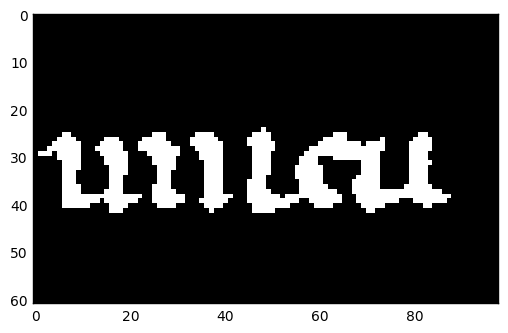

In [55]:
u.plot_image(iu.load_sample("not_code/words/unicu2.png"), (61, 98))

### Bad cuts

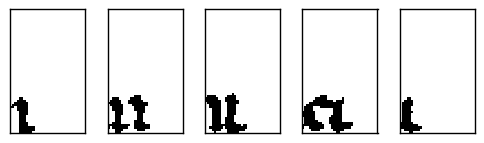

In [56]:
unicu_bad_cuts = iu.open_many_samples( \
                ["not_code/words/bad_cuts/unicu/1.png",
                 "not_code/words/bad_cuts/unicu/2.png",
                 "not_code/words/bad_cuts/unicu/3.png",
                 "not_code/words/bad_cuts/unicu/4.png",
                 "not_code/words/bad_cuts/unicu/5.png"])
(unicu_bad_cuts, _) = kiu.adjust_input(np.asarray(unicu_bad_cuts))

u.plot_some_images(unicu_bad_cuts, (img_cols, img_rows), grid_x=5, grid_y=1)

#### Pipeline 1 (22 networks as segmentator and classifier)

In [57]:
predict_pipeline1(unicu_bad_cuts)

Predictions for the supposed letter number 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 80.8076024055%
---
Predictions for the supposed letter number 2
Cut 2 has been classified as good corresponding to char 'n' with a confidence of 71.514415741%
Cut 2 has been classified as good corresponding to char 'u' with a confidence of 83.6339771748%
---
Predictions for the supposed letter number 3
Cut 3 has been classified as good corresponding to char 'u' with a confidence of 79.0891766548%
---
Predictions for the supposed letter number 4
Cut 4 has been classified as good corresponding to char 'c' with a confidence of 82.5015068054%
---
Predictions for the supposed letter number 5
Cut 5 has been classified as good corresponding to char 'i' with a confidence of 86.4203810692%
---
Elapsed time: 0.5087378025054932


**Possible word:** iuuci

#### Pipeline 2 (segmentator + classifier)

In [58]:
predict_pipeline2(unicu_bad_cuts)

Predictions for the supposed letter number 1
Bad cut with a confidence of 83.9403033257%
---
Predictions for the supposed letter number 2
Good cut corresponding to letter 'u' with a confidence of 50.4490017891%
Good cut corresponding to letter 'n' with a confidence of 49.5443284512%
Good cut corresponding to letter 'o' with a confidence of 0.00620228602202%
---
Predictions for the supposed letter number 3
Good cut corresponding to letter 'u' with a confidence of 93.8818335533%
Good cut corresponding to letter 'n' with a confidence of 3.68343293667%
Good cut corresponding to letter 'e' with a confidence of 2.12449673563%
---
Predictions for the supposed letter number 4
Bad cut with a confidence of 99.9994397163%
---
Predictions for the supposed letter number 5
Bad cut with a confidence of 66.4269268513%
---
Elapsed time: 0.04206085205078125


**Possible word:** -uu--

#### Pipeline 3 (22 networks as segmentator + classifier)

In [59]:
predict_pipeline3(unicu_bad_cuts)

Predictions for the supposed letter number 1
Good cut with a confidence of 80.8076024055% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9758720398%
Good cut corresponding to letter 'a' with a confidence of 0.0145749741932%
Good cut corresponding to letter 't' with a confidence of 0.00618704798399%
---
Predictions for the supposed letter number 2
Good cut with a confidence of 71.514415741% by letter 'n'
Good cut with a confidence of 83.6339771748% by letter 'u'
Good cut corresponding to letter 'u' with a confidence of 50.4490017891%
Good cut corresponding to letter 'n' with a confidence of 49.5443284512%
Good cut corresponding to letter 'o' with a confidence of 0.00620228602202%
---
Predictions for the supposed letter number 3
Good cut with a confidence of 79.0891766548% by letter 'u'
Good cut corresponding to letter 'u' with a confidence of 93.8818335533%
Good cut corresponding to letter 'n' with a confidence of 3.68343293667%
Good cut corresponding to lett

**Possible word:** inuoi

#### Pipeline 4 (segmentator + 22 networks as classifier)

In [60]:
predict_pipeline4(unicu_bad_cuts)

Predictions for the supposed letter number 1
Bad cut with a confidence of 83.9403033257%
---
Predictions for the supposed letter number 2
Good cut with a confidence of 71.514415741% by letter 'n'
Good cut with a confidence of 83.6339771748% by letter 'u'
---
Predictions for the supposed letter number 3
Good cut with a confidence of 79.0891766548% by letter 'u'
---
Predictions for the supposed letter number 4
Bad cut with a confidence of 99.9994397163%
---
Predictions for the supposed letter number 5
Bad cut with a confidence of 66.4269268513%
---
Elapsed time: 0.2388460636138916


**Possible word: ** -uu--

### Good cuts

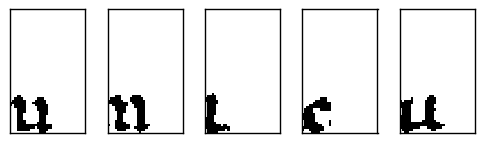

In [61]:
unicu_good_cuts = iu.open_many_samples( \
                ["not_code/words/good_cuts/unicu/u1.png",
                 "not_code/words/good_cuts/unicu/n.png",
                 "not_code/words/good_cuts/unicu/i.png",
                 "not_code/words/good_cuts/unicu/c.png",
                 "not_code/words/good_cuts/unicu/u2.png"])
(unicu_good_cuts, _) = kiu.adjust_input(np.asarray(unicu_good_cuts))

u.plot_some_images(unicu_good_cuts, (img_cols, img_rows), grid_x=5, grid_y=1)

#### Pipeline 1 (22 networks as segmentator and classifier)

In [62]:
predict_pipeline1(unicu_good_cuts)

Predictions for the supposed letter number 1
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 96.2060153484%
---
Predictions for the supposed letter number 2
Cut 2 has been classified as good corresponding to char 'n' with a confidence of 98.1480956078%
Cut 2 has been classified as good corresponding to char 'u' with a confidence of 76.3869464397%
---
Predictions for the supposed letter number 3
Cut 3 has been classified as good corresponding to char 'i' with a confidence of 87.1889472008%
---
Predictions for the supposed letter number 4
Cut 4 has been classified as good corresponding to char 'c' with a confidence of 96.5812563896%
Cut 4 has been classified as good corresponding to char 'e' with a confidence of 64.7963047028%
Cut 4 has been classified as good corresponding to char 'o' with a confidence of 62.8956735134%
---
Predictions for the supposed letter number 5
Cut 5 has been classified as good corresponding to char 'u' with a confidence of 99.183

**Possible word:** unicu

#### Pipeline 2 (segmentator + classifier)

In [63]:
predict_pipeline2(unicu_good_cuts)

Predictions for the supposed letter number 1
Good cut corresponding to letter 'u' with a confidence of 99.8327851295%
Good cut corresponding to letter 'n' with a confidence of 0.167206279002%
Good cut corresponding to letter 'b' with a confidence of 3.91778982589e-06%
---
Predictions for the supposed letter number 2
Good cut corresponding to letter 'n' with a confidence of 99.0177452564%
Good cut corresponding to letter 'u' with a confidence of 0.978748314083%
Good cut corresponding to letter 'o' with a confidence of 0.00336958364642%
---
Predictions for the supposed letter number 3
Good cut corresponding to letter 'i' with a confidence of 99.9894797802%
Good cut corresponding to letter 'l' with a confidence of 0.00764848664403%
Good cut corresponding to letter 't' with a confidence of 0.00252281261055%
---
Predictions for the supposed letter number 4
Good cut corresponding to letter 'c' with a confidence of 99.3064045906%
Good cut corresponding to letter 'e' with a confidence of 0.436

**Possible word:** unicu

#### Pipeline 3 (22 networks as segmentator + classifier)

In [64]:
predict_pipeline3(unicu_good_cuts)

Predictions for the supposed letter number 1
Good cut with a confidence of 96.2060153484% by letter 'u'
Good cut corresponding to letter 'u' with a confidence of 99.8327851295%
Good cut corresponding to letter 'n' with a confidence of 0.167206279002%
Good cut corresponding to letter 'b' with a confidence of 3.91778982589e-06%
---
Predictions for the supposed letter number 2
Good cut with a confidence of 98.1480956078% by letter 'n'
Good cut with a confidence of 76.3869464397% by letter 'u'
Good cut corresponding to letter 'n' with a confidence of 99.0177452564%
Good cut corresponding to letter 'u' with a confidence of 0.978748314083%
Good cut corresponding to letter 'o' with a confidence of 0.00336958364642%
---
Predictions for the supposed letter number 3
Good cut with a confidence of 87.1889472008% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9894797802%
Good cut corresponding to letter 'l' with a confidence of 0.00764848664403%
Good cut corresponding to

**Possible word:** unicu

#### Pipeline 4 (segmentator + 22 networks as classifier)

In [65]:
predict_pipeline4(unicu_good_cuts)

Predictions for the supposed letter number 1
Good cut with a confidence of 96.2060153484% by letter 'u'
---
Predictions for the supposed letter number 2
Good cut with a confidence of 98.1480956078% by letter 'n'
Good cut with a confidence of 76.3869464397% by letter 'u'
---
Predictions for the supposed letter number 3
Good cut with a confidence of 87.1889472008% by letter 'i'
---
Predictions for the supposed letter number 4
Good cut with a confidence of 96.5812563896% by letter 'c'
Good cut with a confidence of 64.7963047028% by letter 'e'
Good cut with a confidence of 62.8956735134% by letter 'o'
---
Predictions for the supposed letter number 5
Good cut with a confidence of 99.1837203503% by letter 'u'
Good cut with a confidence of 55.2794098854% by letter 'q'
---
Elapsed time: 0.46818113327026367


**Possible word: ** unicu

## Experiment 3 ("beneficiu")

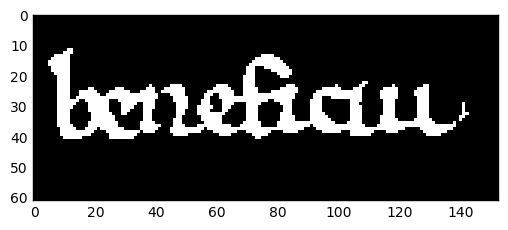

In [66]:
u.plot_image(iu.load_sample("not_code/words/beneficiu.png"), (61, 153))

### Bad cuts

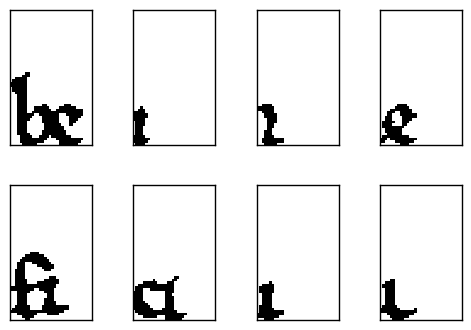

In [67]:
beneficiu_bad_cuts = iu.open_many_samples( \
                    ["not_code/words/bad_cuts/beneficiu/1.png",
                     "not_code/words/bad_cuts/beneficiu/2.png",
                     "not_code/words/bad_cuts/beneficiu/3.png",
                     "not_code/words/bad_cuts/beneficiu/4.png",
                     "not_code/words/bad_cuts/beneficiu/5.png",
                     "not_code/words/bad_cuts/beneficiu/6.png",
                     "not_code/words/bad_cuts/beneficiu/7.png",
                     "not_code/words/bad_cuts/beneficiu/8.png"])
(beneficiu_bad_cuts, _) = kiu.adjust_input(np.asarray(beneficiu_bad_cuts))

u.plot_some_images(beneficiu_bad_cuts, (img_cols, img_rows), grid_x=4, grid_y=2)

#### Pipeline 1 (22 networks as segmentator and classifier)

In [68]:
predict_pipeline1(beneficiu_bad_cuts)

Predictions for the supposed letter number 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 89.7515118122%
Cut 1 has been classified as good corresponding to char 'b' with a confidence of 85.8027815819%
---
Predictions for the supposed letter number 2
Cut 2 has been classified as good corresponding to char 'i' with a confidence of 73.2650399208%
---
Predictions for the supposed letter number 3
Cut 3 has been classified as good corresponding to char 'i' with a confidence of 88.278067112%
---
Predictions for the supposed letter number 4
Cut 4 has been classified as good corresponding to char 'e' with a confidence of 97.7854728699%
Cut 4 has been classified as good corresponding to char 'o' with a confidence of 72.0082223415%
---
Predictions for the supposed letter number 5
Cut 5 has been classified as good corresponding to char 's_mediana' with a confidence of 99.8350143433%
Cut 5 has been classified as good corresponding to char 'f' with a confi

**Possible word:** siiescii

#### Pipeline 2 (segmentator + classifier)

In [69]:
predict_pipeline2(beneficiu_bad_cuts)

Predictions for the supposed letter number 1
Bad cut with a confidence of 99.9998927116%
---
Predictions for the supposed letter number 2
Bad cut with a confidence of 78.9120316505%
---
Predictions for the supposed letter number 3
Bad cut with a confidence of 67.4514889717%
---
Predictions for the supposed letter number 4
Good cut corresponding to letter 'e' with a confidence of 99.9559521675%
Good cut corresponding to letter 'o' with a confidence of 0.0432997388998%
Good cut corresponding to letter 'c' with a confidence of 0.000737727259548%
---
Predictions for the supposed letter number 5
Good cut corresponding to letter 'f' with a confidence of 99.9757766724%
Good cut corresponding to letter 's_alta' with a confidence of 0.0241572299274%
Good cut corresponding to letter 'b' with a confidence of 4.61786157757e-05%
---
Predictions for the supposed letter number 6
Bad cut with a confidence of 99.9706625938%
---
Predictions for the supposed letter number 7
Bad cut with a confidence of 7

**Possible word:** ---ef--i

#### Pipeline 3 (22 networks as segmentator + classifier)

In [70]:
predict_pipeline3(beneficiu_bad_cuts)

Predictions for the supposed letter number 1
Good cut with a confidence of 89.7515118122% by letter 's_mediana'
Good cut with a confidence of 85.8027815819% by letter 'b'
Good cut corresponding to letter 'b' with a confidence of 99.5801329613%
Good cut corresponding to letter 'h' with a confidence of 0.418522907421%
Good cut corresponding to letter 'f' with a confidence of 0.00134383126351%
---
Predictions for the supposed letter number 2
Good cut with a confidence of 73.2650399208% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.966686964%
Good cut corresponding to letter 'a' with a confidence of 0.0256100436673%
Good cut corresponding to letter 't' with a confidence of 0.00342105995514%
---
Predictions for the supposed letter number 3
Good cut with a confidence of 88.278067112% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9939143658%
Good cut corresponding to letter 'a' with a confidence of 0.00526739640918%
Good cut correspond

**Possible word:** biiefoii

#### Pipeline 4 (segmentator + 22 networks as classifier)

In [71]:
predict_pipeline4(beneficiu_bad_cuts)

Predictions for the supposed letter number 1
Bad cut with a confidence of 99.9998927116%
---
Predictions for the supposed letter number 2
Bad cut with a confidence of 78.9120316505%
---
Predictions for the supposed letter number 3
Bad cut with a confidence of 67.4514889717%
---
Predictions for the supposed letter number 4
Good cut with a confidence of 97.7854728699% by letter 'e'
Good cut with a confidence of 72.0082223415% by letter 'o'
---
Predictions for the supposed letter number 5
Good cut with a confidence of 99.8350143433% by letter 's_mediana'
Good cut with a confidence of 90.257871151% by letter 'f'
---
Predictions for the supposed letter number 6
Bad cut with a confidence of 99.9706625938%
---
Predictions for the supposed letter number 7
Bad cut with a confidence of 79.6034812927%
---
Predictions for the supposed letter number 8
Good cut with a confidence of 92.2721743584% by letter 'i'
---
Elapsed time: 0.36803197860717773


**Possible word: ** ---ef--i

### Good cuts

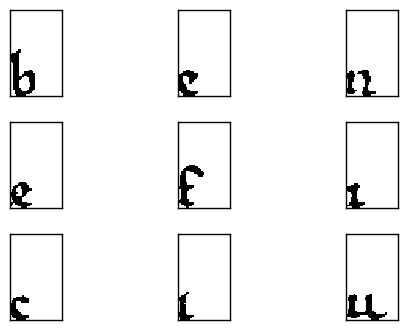

In [72]:
beneficiu_good_cuts = iu.open_many_samples( \
                    ["not_code/words/good_cuts/beneficiu/b.png",
                     "not_code/words/good_cuts/beneficiu/e1.png",
                     "not_code/words/good_cuts/beneficiu/n.png",
                     "not_code/words/good_cuts/beneficiu/e2.png",
                     "not_code/words/good_cuts/beneficiu/f.png",
                     "not_code/words/good_cuts/beneficiu/i1.png",
                     "not_code/words/good_cuts/beneficiu/c.png",
                     "not_code/words/good_cuts/beneficiu/i2.png",
                     "not_code/words/good_cuts/beneficiu/u.png"])
(beneficiu_good_cuts, _) = kiu.adjust_input(np.asarray(beneficiu_good_cuts))

u.plot_some_images(beneficiu_good_cuts, (img_cols, img_rows), grid_x=3, grid_y=3)

#### Pipeline 1 (22 networks as segmentator and classifier)

In [73]:
predict_pipeline1(beneficiu_good_cuts)

Predictions for the supposed letter number 1
Cut 1 has been classified as good corresponding to char 'b' with a confidence of 96.2968468666%
Cut 1 has been classified as good corresponding to char 'h' with a confidence of 95.1756775379%
---
Predictions for the supposed letter number 2
Cut 2 has been classified as good corresponding to char 'e' with a confidence of 99.0915298462%
Cut 2 has been classified as good corresponding to char 'o' with a confidence of 72.757101059%
---
Predictions for the supposed letter number 3
Cut 3 has been classified as good corresponding to char 'n' with a confidence of 81.7161262035%
Cut 3 has been classified as good corresponding to char 'u' with a confidence of 87.449246645%
---
Predictions for the supposed letter number 4
Cut 4 has been classified as good corresponding to char 'e' with a confidence of 97.0624148846%
Cut 4 has been classified as good corresponding to char 'o' with a confidence of 68.0127263069%
---
Predictions for the supposed letter nu

**Possible word:** beuesiciu

#### Pipeline 2 (segmentator + classifier)

In [74]:
predict_pipeline2(beneficiu_good_cuts)

Predictions for the supposed letter number 1
Good cut corresponding to letter 'b' with a confidence of 98.3484447002%
Good cut corresponding to letter 'h' with a confidence of 1.65152195841%
Good cut corresponding to letter 'l' with a confidence of 3.59929885008e-05%
---
Predictions for the supposed letter number 2
Good cut corresponding to letter 'e' with a confidence of 99.9595344067%
Good cut corresponding to letter 'o' with a confidence of 0.0318640668411%
Good cut corresponding to letter 'c' with a confidence of 0.00851618387969%
---
Predictions for the supposed letter number 3
Good cut corresponding to letter 'n' with a confidence of 70.486342907%
Good cut corresponding to letter 'u' with a confidence of 29.4608056545%
Good cut corresponding to letter 'o' with a confidence of 0.0492571678478%
---
Predictions for the supposed letter number 4
Good cut corresponding to letter 'e' with a confidence of 99.8720526695%
Good cut corresponding to letter 'o' with a confidence of 0.12600704

**Possible word:** benes-c-u or benef-c-u with a lower chance

#### Pipeline 3 (22 networks as segmentator + classifier)

In [75]:
predict_pipeline3(beneficiu_good_cuts)

Predictions for the supposed letter number 1
Good cut with a confidence of 96.2968468666% by letter 'b'
Good cut with a confidence of 95.1756775379% by letter 'h'
Good cut corresponding to letter 'b' with a confidence of 98.3484447002%
Good cut corresponding to letter 'h' with a confidence of 1.65152195841%
Good cut corresponding to letter 'l' with a confidence of 3.59929885008e-05%
---
Predictions for the supposed letter number 2
Good cut with a confidence of 99.0915298462% by letter 'e'
Good cut with a confidence of 72.757101059% by letter 'o'
Good cut corresponding to letter 'e' with a confidence of 99.9595344067%
Good cut corresponding to letter 'o' with a confidence of 0.0318640668411%
Good cut corresponding to letter 'c' with a confidence of 0.00851618387969%
---
Predictions for the supposed letter number 3
Good cut with a confidence of 81.7161262035% by letter 'n'
Good cut with a confidence of 87.449246645% by letter 'u'
Good cut corresponding to letter 'n' with a confidence of 

**Possible word:** benesiciu or beneficiu with a lower chance

#### Pipeline 4 (segmentator + 22 networks as classifier)

In [76]:
predict_pipeline4(beneficiu_good_cuts)

Predictions for the supposed letter number 1
Good cut with a confidence of 96.2968468666% by letter 'b'
Good cut with a confidence of 95.1756775379% by letter 'h'
---
Predictions for the supposed letter number 2
Good cut with a confidence of 99.0915298462% by letter 'e'
Good cut with a confidence of 72.757101059% by letter 'o'
---
Predictions for the supposed letter number 3
Good cut with a confidence of 81.7161262035% by letter 'n'
Good cut with a confidence of 87.449246645% by letter 'u'
---
Predictions for the supposed letter number 4
Good cut with a confidence of 97.0624148846% by letter 'e'
Good cut with a confidence of 68.0127263069% by letter 'o'
---
Predictions for the supposed letter number 5
Good cut with a confidence of 99.703091383% by letter 's_mediana'
Good cut with a confidence of 98.1592357159% by letter 's_alta'
Good cut with a confidence of 90.327167511% by letter 'f'
---
Predictions for the supposed letter number 6
Bad cut with a confidence of 98.6966431141%
---
Pred

**Possible word: ** beues-c-u

## Results
Overall the pipeline 2 (segmentator + classifier) seems to give the best results. Pipeline 1 and 3 behave correctly when cuts are good, but they are totally unaware of bad cuts, giving false positives with almost 100% confidence. Pipeline 2 on the other hand gives sometimes false negatives on good cuts of the letter "i", but that's because of the training set of the segmentator network, that has been trained with bad cuts of letter "m", "n" and "u" almost identical to a good cut of an "i". Polishing the dataset should give a better false positive over false negative ratio. 